# Enron email analysis

This report focuses on multi class classification of the enron email dataset. Let's have a look at the step by step procedure.

**Imorting required libraries**

In [1]:
import sys
# import email
import re
import glob
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from helper import *
%matplotlib inline
sns.set_style('whitegrid')
# pd.set_option('display.max_colwidth', -1)

## Data load
### Creating a data set containing file paths

In [2]:
all_txt = glob.glob('enron_with_categories/' + '**/*txt', recursive = True)

In [3]:
all_txt_df = pd.DataFrame({'file_loc' : all_txt})

In [4]:
all_txt_df['name'] = all_txt_df.file_loc.apply(lambda x: x.split('/')[-1])

In [5]:
all_txt_df['cat_file_loc'] = all_txt_df.file_loc.apply(lambda x: x.replace('.txt', '.cats'))

In [6]:
all_txt_df.head()

,file_loc,name,cat_file_loc
0,enron_with_categories/categories.txt,categories.txt,enron_with_categories/categories.cats
1,enron_with_categories/1/10425.txt,10425.txt,enron_with_categories/1/10425.cats
2,enron_with_categories/1/106296.txt,106296.txt,enron_with_categories/1/106296.cats
3,enron_with_categories/1/106298.txt,106298.txt,enron_with_categories/1/106298.cats
4,enron_with_categories/1/106588.txt,106588.txt,enron_with_categories/1/106588.cats


### Read files

In [7]:
cl, catl = read_files(all_txt_df)

In [8]:
all_txt_df['raw_content'] = cl
all_txt_df['raw_cats'] = catl
all_txt_df.to_csv('cats_email.csv', index = False)

### Feature extraction

The function `get_cat` extracts the category id and emotion tone of the message from the information contained in category files.

In [9]:
all_txt_df['cat_id'] = all_txt_df.raw_cats.apply(lambda x: get_cat(x, 1))
all_txt_df['emo_tone'] = all_txt_df.raw_cats.apply(lambda x: get_cat(x, 4))
all_txt_df.head()

,file_loc,name,cat_file_loc,raw_content,raw_cats,cat_id,emo_tone
0,enron_with_categories/categories.txt,categories.txt,enron_with_categories/categories.cats,,,None,None
1,enron_with_categories/1/10425.txt,10425.txt,enron_with_categories/1/10425.cats,Message-ID: <197504.1075840201539.JavaMail.eva...,"1,1,1\n2,6,1\n2,13,1\n3,3,1\n",1,None
2,enron_with_categories/1/106296.txt,106296.txt,enron_with_categories/1/106296.cats,Message-ID: <11991339.1075842536086.JavaMail.e...,"1,1,2\n3,6,2\n4,10,2\n",1,10
3,enron_with_categories/1/106298.txt,106298.txt,enron_with_categories/1/106298.cats,Message-ID: <7106753.1075842536132.JavaMail.ev...,"1,1,1\n1,6,1\n2,1,1\n2,2,2\n3,6,2\n3,7,1\n4,10...",1,10
4,enron_with_categories/1/106588.txt,106588.txt,enron_with_categories/1/106588.cats,Message-ID: <21267718.1075863331587.JavaMail.e...,"1,1,2\n2,1,2\n2,2,2\n3,6,2\n3,10,2\n",1,None


In [10]:
emails = all_txt_df.copy()
emails.raw_content = emails.raw_content.astype('str')
emails = emails[1:]
emails.head()

,file_loc,name,cat_file_loc,raw_content,raw_cats,cat_id,emo_tone
1,enron_with_categories/1/10425.txt,10425.txt,enron_with_categories/1/10425.cats,Message-ID: <197504.1075840201539.JavaMail.eva...,"1,1,1\n2,6,1\n2,13,1\n3,3,1\n",1,None
2,enron_with_categories/1/106296.txt,106296.txt,enron_with_categories/1/106296.cats,Message-ID: <11991339.1075842536086.JavaMail.e...,"1,1,2\n3,6,2\n4,10,2\n",1,10
3,enron_with_categories/1/106298.txt,106298.txt,enron_with_categories/1/106298.cats,Message-ID: <7106753.1075842536132.JavaMail.ev...,"1,1,1\n1,6,1\n2,1,1\n2,2,2\n3,6,2\n3,7,1\n4,10...",1,10
4,enron_with_categories/1/106588.txt,106588.txt,enron_with_categories/1/106588.cats,Message-ID: <21267718.1075863331587.JavaMail.e...,"1,1,2\n2,1,2\n2,2,2\n3,6,2\n3,10,2\n",1,None
5,enron_with_categories/1/106590.txt,106590.txt,enron_with_categories/1/106590.cats,Message-ID: <20866019.1075863331634.JavaMail.e...,"1,1,1\n3,6,1\n3,10,1\n4,10,1\n",1,10


In [11]:
print(emails.isnull().sum())
print(len(emails))

file_loc           0
name               0
cat_file_loc       0
raw_content        0
raw_cats           0
cat_id             0
emo_tone        1392
dtype: int64
1702


In [12]:
emails = emails.drop('emo_tone', axis = 1)

As the column `emo_tone` didn't have much information, we can delete it entirely. Below are some useful information extracted from the raw_content of each email.

In [13]:
messages = parse_into_emails(emails.raw_content)
emails['subject'] = messages['subject']
emails['body'] = messages['body']
emails['to'] = messages['to']
emails['from_'] = messages['from_']

Combining both subject and body to one column

In [14]:
emails["content"] = emails["subject"].map(str) + " " + emails["body"]
emails.drop(['subject', 'body', 'raw_content', 'raw_cats'], axis=1, inplace = True)

I have only used the word lemmatizer. Stemming the words didn't give better result.

In [15]:
lemmatizer = WordNetLemmatizer()
content_lemma = [' '.join([lemmatizer.lemmatize(word.strip(',;!?".')) for word in content.split()]) for content in emails.content]
emails.content = content_lemma
# stemmer = PorterStemmer()
# content_stem = [' '.join([stemmer.stem(word) for word in content.split()]) for content in emails.content]
# emails.content = content_stem
emails.head()

,file_loc,name,cat_file_loc,cat_id,to,from_,content
1,enron_with_categories/1/10425.txt,10425.txt,enron_with_categories/1/10425.cats,1,Andrew Morrison/LON/ECT@ECT,steven.kean@enron.com,Translation of article jeff.skilling@enron.com...
2,enron_with_categories/1/106296.txt,106296.txt,enron_with_categories/1/106296.cats,1,darrell.schoolcraft@enron.com,drew.fossum@enron.com,TW Gas Sales In anticipation of potential liti...
3,enron_with_categories/1/106298.txt,106298.txt,enron_with_categories/1/106298.cats,1,Darrell Schoolcraft/ET&S/Enron@ENRON,drew.fossum@enron.com,TW Gas Sales Julia and Steve--here are some qu...
4,enron_with_categories/1/106588.txt,106588.txt,enron_with_categories/1/106588.cats,1,Darrell Schoolcraft/ET&S/Enron@ENRON,drew.fossum@enron.com,TW Gas Sales Julia and Steve--here are some qu...
5,enron_with_categories/1/106590.txt,106590.txt,enron_with_categories/1/106590.cats,1,darrell.schoolcraft@enron.com,drew.fossum@enron.com,TW Gas Sales 1 What are the specific pressure ...


### TF-IDF

In [16]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])

Let's have a look at the class distribution of our dataset.

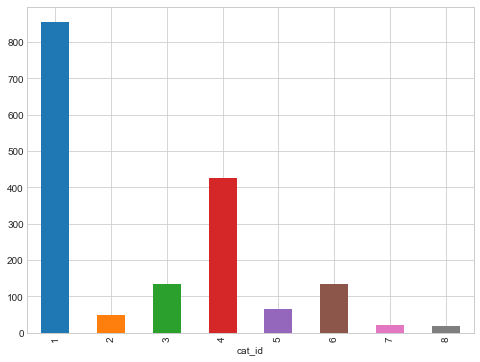

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
emails.groupby('cat_id').content.count().plot.bar(ylim=0)
plt.show()

The plot above shows huge class imbalance. Below is the description of each category.
1. Company Business, Strategy, etc. (elaborate in Section 3 [Topics])

2. Purely Personal

3. Personal but in professional context (e.g., it was good working with you)

4. Logistic Arrangements (meeting scheduling, technical support, etc)

5. Employment arrangements (job seeking, hiring, recommendations, etc)

6. Document editing/checking (collaboration)

7. Empty message (due to missing attachment)

8. Empty message

In [18]:
vect = TfidfVectorizer(analyzer='word', sublinear_tf=True, max_df=0.3, min_df=2, norm='l2',\
                        encoding='latin-1', stop_words=stopwords)

In [19]:
#features = tfidf.fit_transform(emails.content).toarray()
X = vect.fit_transform(emails.content)
feats = vect.get_feature_names()
#X.shape
features = X.toarray()
labels = emails.cat_id
features.shape

(1702, 20933)

1702 is the number of documents and 20933 is the count of unique words across all the documents. `features` is a numpy ndarray having the above dimension where each entry corresponds to a TF-IDF score of a word document pair. 

In [20]:
# Let's print the top 10 terms in document 1
print(top_feats_in_doc(X, feats, 1, 5))

      features     score
0           tw  0.285613
1  operational  0.269541
2         sale  0.243291
3       border  0.227247
4       excess  0.179669


In [21]:
# Now we print the top terms across all documents.
print(top_mean_feats(X, feats, None, 0.1, 5))

   features     score
0       ees  0.016379
1     vince  0.012905
2   meeting  0.009735
3        na  0.009440
4  original  0.008785


### Model comparison
Now let's have a look at the performances of random forest, support vector machine, naive bayes and logistic regression.

In [22]:
models = [
    RandomForestClassifier(n_estimators=500, min_samples_leaf=3, random_state=0, n_jobs = -1),
    LinearSVC(),
    MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
    LogisticRegression(random_state=0, C=0.4, penalty='l2', class_weight = 'balanced'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Let's plot the accuracy of each model for all the iterations.

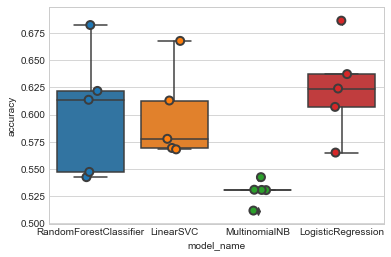

In [23]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.599125
LogisticRegression        0.623884
MultinomialNB             0.529347
RandomForestClassifier    0.601469
Name: accuracy, dtype: float64

Seems like random forest and logistic regressions doing a better job than other models. Let's try to tune these models and see their performance.

### Performance of Linear SVM

In [25]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, emails.index, test_size=0.33, random_state=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print("Accuracy: {}".format(sum([a==b for a, b in zip(y_test, y_pred)])*100.0/len(y_test)))

Accuracy: 64.94661921708185


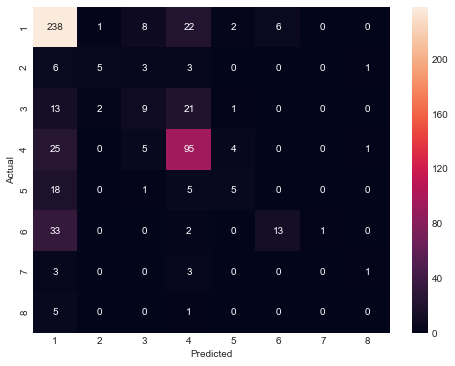

In [27]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(emails.cat_id.unique()), yticklabels=list(emails.cat_id.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

From the above confusion matrix we can see, in category 1 and 4 most of the emails are classified correctly. But in all other categories the performance is poor because of class imbalance.

### Performance of logistic regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=10)
logreg = LogisticRegression(C=1, penalty='l2', class_weight = 'balanced', n_jobs=-1)
logreg.fit(X_train, y_train)

/Users/bcl458/anaconda2/envs/py_3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67906


### Performance of Naive Bayes

In [30]:
max_df = [0.2, 0.25, 0.35, 0.45, 0.55, 0.65, 0.8]
min_df = [10,20,30,40,50,60,70,80,90,100]
scores = []
shapes = []
for i in max_df:
    for j in min_df:
        count_vect = CountVectorizer(max_df=i, min_df=j)
        email_counts = count_vect.fit_transform(emails.content)
        tfidf_transformer = TfidfTransformer()
        email_tfidf = tfidf_transformer.fit_transform(email_counts)
        clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True).fit(email_tfidf, emails.cat_id)
        scores.append(clf.score(email_tfidf, emails.cat_id))
        shapes.append(email_tfidf.shape)

In [31]:
score_nb = pd.DataFrame({'max_df': list(np.repeat(max_df,10)), 'min_df': min_df*7, 'scores' : scores, 'shapes' : shapes})
score_nb.sort_values(by='scores', ascending=False).head(1)

,max_df,min_df,scores,shapes
4,0.2,50,0.665687,"(1702, 1981)"


In [32]:
count_vect = CountVectorizer(max_df=0.2, min_df=50)
email_counts = count_vect.fit_transform(emails.content)
tfidf_transformer = TfidfTransformer()
email_tfidf = tfidf_transformer.fit_transform(email_counts)
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True).fit(email_tfidf, emails.cat_id)
print(clf.score(email_tfidf, emails.cat_id), email_tfidf.shape)
confusion_matrix(emails.cat_id, clf.predict(email_tfidf))

0.6656874265569918 (1702, 1981)


array([[815,   0,   0,  40,   0,   0,   0,   0],
       [ 30,   1,   0,  17,   0,   0,   0,   0],
       [ 87,   0,  13,  35,   0,   0,   0,   0],
       [124,   0,   0, 302,   0,   0,   0,   0],
       [ 46,   0,   0,  18,   0,   0,   0,   0],
       [119,   0,   0,  14,   0,   2,   0,   0],
       [ 17,   0,   0,   4,   0,   0,   0,   0],
       [ 16,   0,   0,   2,   0,   0,   0,   0]])

The model is doing a great job for category 1 and some what descent job for category 4. But all other categories are victims of class imbalance.

### Performance of Random Forest

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)
m = RandomForestClassifier(n_jobs = -1, n_estimators=100)

In [ ]:
# params = {
#     'min_samples_split' : [3, 5, 7, 10],
#     'max_depth' : [6, 7, 8, 10, 11],
#     'max_features' : [0.8, 'sqrt', 'log2', 0.6]
# }
# from sklearn.model_selection import GridSearchCV
# fgrid = GridSearchCV(estimator = m, param_grid = params, cv = 3, verbose = 50)
# fgrid.fit(X_train, y_train)

In [129]:
# print(fgrid.best_params_)

{'max_depth': 7, 'max_features': 0.6, 'min_samples_split': 10}


By running a grid search with 3 fold cross validation *(as given in the above 2 cells)*, I fould the best parameters as given above. Below I am fitting a random forest classifier with 500 trees along with these parameters.

In [37]:
m = RandomForestClassifier(n_jobs = -1, n_estimators=500, max_depth = 7, min_samples_split = 10, max_features = 0.6)
m.fit(X_train, y_train)
res = [m.score(X_train, y_train), m.score(X_test, y_test)]
print(res)

[0.6960537363560033, 0.6125244618395304]


From the above analysis, logistic regression seems to perform a better job than all others.